In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

Text(0, 0.5, 'x')

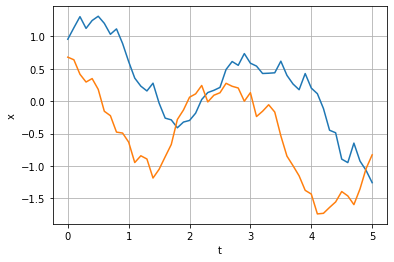

In [2]:
# Make sample paths and data sets
Dt = 1.0e-3          # Delta t for Euler-Maruyama method
Dt_obs = 1.0e-1      # Time-interval for snapshot pairs
T = 5.0             # Final time for a sample path
num_ensembles = 10

# Set parameters
dim = 2
epsilon = 1.0
nu11 = 0.5
nu22 = 0.5

# Set function for the drift and diffusion terms
def drift(x, t):
    f1 = x[1]
    f2 = epsilon*x[1]*(1.0-x[0]*x[0]) - x[0]
    return np.array([f1,f2])
def diff(x, t):
    s1 = nu11
    s2 = nu22
    return np.array([s1,s2])

# Perform Monte Carlo simulations
np.random.seed(3633914)
X = [] # 1st data matrix for EDMD
Y = [] # 2nd data matrix for EDMD
time_array = np.arange(0, T+Dt, Dt)
obs_time_array = np.arange(0, T+Dt_obs, Dt_obs)
for s in range(num_ensembles):
    x = np.zeros(dim)
    dW = np.random.normal(scale=np.sqrt(Dt), size=(len(time_array)-1, dim))
    x = np.random.uniform(low=-1.0, high=1.0, size=(dim))
    obs_t = 0.0
    result = []
    for i, t in enumerate(time_array[:-1]):
        x = x + drift(x,t)*Dt + diff(x,t)*dW[i]
        if t+Dt >= (obs_t-1.0e-6):
            obs_t = obs_t + Dt_obs
            result.append(x)
    X.extend(result[:-1])
    Y.extend(result[1:])
X = np.array(X)
Y = np.array(Y)

# Plot the final time-series data (for check)
result = np.array(result)
plt.grid()
plt.plot(obs_time_array, result)
plt.xlabel('t')
plt.ylabel('x')

In [3]:
# Define subroutines for the monomial dictionary
def make_monomial_powers(dim, max_order):
    max_orders = max_order * np.ones(dim, dtype="int8") + 1
    max_orders = max_orders.tolist()
    rev_max_orders = list(max_orders)
    rev_max_orders.reverse()
    rev_max_orders_cumprod = np.cumprod(rev_max_orders)
    total_states = rev_max_orders_cumprod[-1]
    rev_max_orders_cumprod = rev_max_orders_cumprod[:-1]
    def calc_index2degree(i):
        n = []
        val = i
        for cumprod in reversed(rev_max_orders_cumprod):
            q, mod = divmod(val, cumprod)
            n.append(q)
            val = mod
        n.append(val)
        return(n)
    comp = []
    for i in range(total_states):
        comp.append(calc_index2degree(i))
    comp = np.array(comp)
    # remove elements over the max_degree
    comp = comp[comp.sum(axis=1) <= max_order]
    # sort
    for_sort = comp.sum(axis=1)
    comp = comp[np.argsort(for_sort)]
    return comp

class monomials(object):
    def __init__(self, max_order):
        self.max_order = max_order

    def __call__(self, x):
        d = x.shape[0]
        list_exponent = make_monomial_powers(d, self.max_order)
        result_powers = np.power(x, list_exponent)
        vec_psi = np.prod(result_powers, axis=1)
        return vec_psi[:,np.newaxis]

In [4]:
# For check
list_exponent = make_monomial_powers(x.shape[0], 5)
print(list_exponent)

[[0 0]
 [0 1]
 [1 0]
 [0 2]
 [1 1]
 [2 0]
 [0 3]
 [1 2]
 [2 1]
 [3 0]
 [0 4]
 [4 0]
 [1 3]
 [2 2]
 [3 1]
 [3 2]
 [1 4]
 [4 1]
 [0 5]
 [2 3]
 [5 0]]


In [5]:
# Define the main routine for the EDMD
def edmd(X, Y, psi):
    '''
    EDMD algorithm. The inputs are the matricies X and Y for the snapshot pairs.
    
    :param psi:      Basis functions, which will be given as a class object.
    :return:         Koopman matrix K.
    '''
    m = psi(X[0]).shape[0]
    A = np.zeros([m,m])
    G = np.zeros([m,m])
    for x, y in zip(X, Y):
        psi_x = psi(x)
        psi_y = psi(y)
        A = A + psi_y @ psi_x.T
        G = G + psi_x @ psi_x.T
    K = A @ linalg.pinv(G)
    return K

In [6]:
# Evaluate the Koopman matrix and output it
max_order_of_monomials = 5
K = edmd(X, Y, psi=monomials(max_order_of_monomials))

output_filename = "Koopman_matrix_for_van_der_Pol.dat"
maximum_output = 6
output = ""
for i in range(maximum_output):
    output_line = ""
    for j in range(maximum_output):
        output_line = output_line + "{0:+.14e} ".format(K[i,j])
    output = output + output_line + "\n"

with open(output_filename, mode='w') as f:
    f.write(output)

# for check
print(output)

+1.00000000000003e+00 +5.27180623827654e-13 -5.58425839541814e-14 -4.77883423992689e-14 -1.71689697328406e-13 +1.55931515126902e-14 
+1.09031630038635e-02 +1.04255106268341e+00 -1.23862656362419e-01 +4.59598646622961e-03 +7.52539318537529e-03 -1.42449687885200e-02 
+2.52043289112318e-02 +1.73164658718394e-01 +9.75414116329335e-01 -2.77807058525071e-02 +6.57122618887072e-02 -4.11667848873710e-02 
+1.90858739505937e-02 +7.95047401529063e-02 +7.08045982868001e-02 +1.15881152448504e+00 -2.74993243538220e-01 +3.03740929940490e-02 
+3.33778092522539e-02 +6.77654294443713e-02 -2.15228889729603e-02 +6.63143515201458e-02 +1.13933932119824e+00 -1.45124259369094e-01 
-4.77576135761718e-03 +2.83838088426397e-02 -1.28544590408603e-01 +3.65220400037090e-02 +2.50108817778501e-01 +1.10860281845803e+00 



In [7]:
# Perform Monte Carlo simulations for check
data_num = 25
psi = monomials(max_order_of_monomials)
print("State: [{0}, {1}]".format(X[data_num,0],X[data_num,1]))
MC_result = []
num_samples = 100
num_ensembles = 10
time_array = np.arange(0, Dt_obs, Dt)
for s in range(num_ensembles):
    y_stat = []
    for n in range(num_samples):
        dW = np.random.normal(scale=np.sqrt(Dt), size=(len(time_array), dim))
        x = X[data_num]
        for i, t in enumerate(time_array):
            x = x + drift(x,t)*Dt + diff(x,t)*dW[i]
        y_stat.append(psi(x)[1:6].T)
    MC_result.append(np.mean(y_stat, axis=0)[0])
MC_result = np.array(MC_result)
MC_mean = np.mean(MC_result, axis=0)
MC_std = np.std(MC_result, axis=0)

# Evaluate the statistics with the Koopman matrix
psi_x = psi(X[data_num])
K_result = K @ psi_x

print("[next x1]")
print("Koopman: {0:+.12e}".format(K_result[1,0]))
print("MC     : {0:+.12e} +/- {1:.12e}".format(MC_mean[0], MC_std[0]))
print("[next x2]")
print("Koopman: {0:+.12e}".format(K_result[2,0]))
print("MC     : {0:+.12e} +/- {1:.12e}".format(MC_mean[1], MC_std[1]))
print("[next x1^2]")
print("Koopman: {0:+.12e}".format(K_result[3,0]))
print("MC     : {0:+.12e} +/- {1:.12e}".format(MC_mean[2], MC_std[2]))
print("[next x1 x2]")
print("Koopman: {0:+.12e}".format(K_result[4,0]))
print("MC     : {0:+.12e} +/- {1:.12e}".format(MC_mean[3], MC_std[3]))
print("[next x2^2]")
print("Koopman: {0:+.12e}".format(K_result[5,0]))
print("MC     : {0:+.12e} +/- {1:.12e}".format(MC_mean[4], MC_std[4]))

State: [1.340798637337331, -0.332110067670004]
[next x1]
Koopman: -4.631385002177e-01
MC     : -4.344319935240e-01 +/- 1.860216264823e-02
[next x2]
Koopman: +1.294938751747e+00
MC     : +1.298248740936e+00 +/- 1.013011836663e-02
[next x1^2]
Koopman: +2.812280026228e-01
MC     : +2.121557759573e-01 +/- 1.510429539573e-02
[next x1 x2]
Koopman: -5.951708016806e-01
MC     : -5.629765064464e-01 +/- 2.612543695482e-02
[next x2^2]
Koopman: +1.763646450874e+00
MC     : +1.710475198036e+00 +/- 2.742130940703e-02
